<a href="https://colab.research.google.com/github/An0816/DCGAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/An0816/celebA.git

Cloning into 'celebA'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [ ]:
!ls

celebA	drive  sample_data


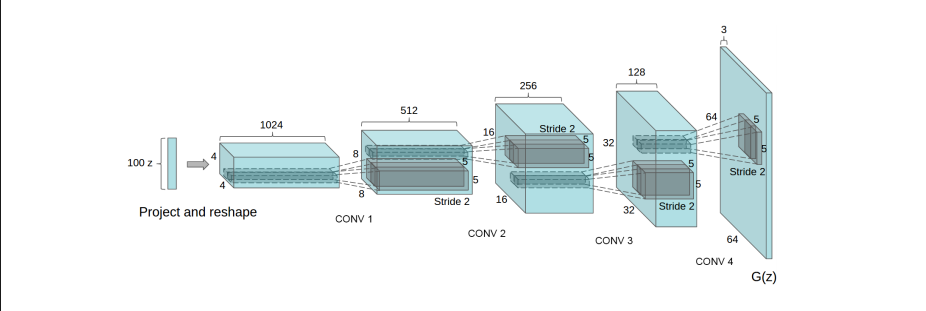

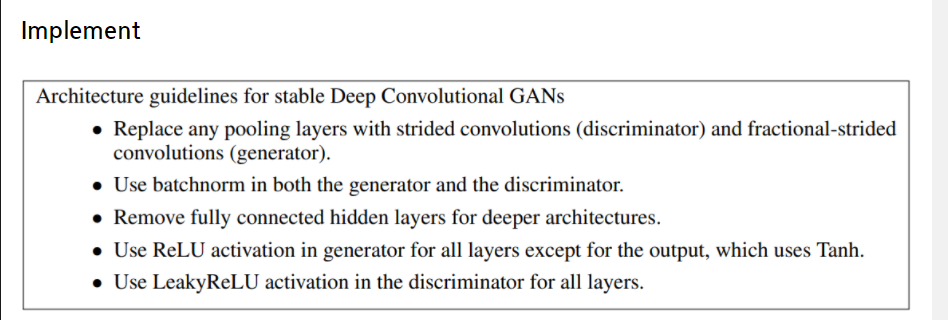

#### transpose convolution 
[ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

: increase its spacial size  
(= fractionally strided convolution)  
(= Backward strided convolution)  
`torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0, bias = True)`  




#### Batch Norm(Batch Normalization)

[BatchNorm](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
- standardize the input to a layer for each mini-batch  
- standardization = rescaling data to have a mean=0, std=1  
- `torch.nn.BatchNorm2d(num_features, eps = 1e05, momentum = 0.1, affine = True, track_running_stats = True)  
    : input = (N,C,H,W)  #(number of batch, channel, height, width)  
    : output = (N,C,H,W)   
    


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [ ]:
train_image = datasets.ImageFolder(root = '/content/drive/MyDrive/celebA/', 
                                   transform = transforms.Compose([
                                        transforms.Resize(64),
                                        transforms.CenterCrop(64),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
]))

RuntimeError: ignored

In [ ]:
batch_size = 128
train_data = DataLoader(dataset = train_image, batch_size = batch_size, 
                        shuffle = True, drop_last = True)

In [ ]:
# all model weights should be randomly initialized from a normal distribution with mean = 0, std = 0.02
# 그래서 reinitializs all convolutional, convolutional-transpose, and batch normalization layer
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channel = 100, out_channel = 1024, kernel_size = 4, stride = 1, padding = 0),
            nn.BatchNorm2d(num_features = 1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 4, 2, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 0),
            nn.Tanh()
        )
    def forward(self, x):
        x = x.reshape([x.size(0), 100, 1, 1]) # (N, C, H, W)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel = 3, out_channel = 128, kernel_size = 4, stride = 2, padding = 0),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 4, 2, 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, 4, 2, 0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, 4, 2, 0),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1, 4, 1, 0),
            nn.LeakyReLU()
        )
    
    def forward(self, x):
        x = self.model(x)
        x = x.reshape([x.size(0), 1]) # batch_size, dim
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)
G.apply(weight_init)
D = Discriminator().to(device)
D.apply(weight_init)

criterion = nn.BCELoss()
optim_G = torch.optim.Adam(G.parameters(), lr = 0.0001)
optim_D = torch.optim.Adam(D.parameters(), lr = 0.0001)


In [ ]:
# training process
total_epochs = 200
total_batch = len(train_data)

for epoch in range(total_epochs):
    avg_cost = [0, 0]
    for x, y in train_data:
        x = x.to(device)

        z = torch.randn(batch_size, 100, device = device) # noise
        fake_img = G(z)
        real = (torch.FloatTensor(x.size(0), 1).fill_(1.0)).to(device)
        fake = (torch.FloatTensor(x.size(0), 1).fill_(0.0)).to(device)

        # train Generator
        optim_G.zero_grad()
        g_loss = criterion(D(fake_img), real)
        g_loss.backward()
        optim_G.step()

        # train Discriminator
        optim_D.zero_grad()
        real_loss = criterion(D(x), real)
        fake_loss = criterion(D(fake_img), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optim_D.step()

        avg_cost[0] += g_loss
        avg_cost[1] += d_loss
    avg_cost[0] /= total_batch
    avg_cost[1] /= total_batch

    print(f"Epoch : {epcoh+1}, Generator : {avg_cost[0]}, Discriminator : {avg_cost[1]}")

    z = torch.randn(64, 100, device = device)
    fake_img = G(z)
    img_grid = make_grid(fake_img, nrow = 10, normalize = True)
    save_image(img_grid, "/content/drive/MyDrive/Deep Learning/GAN/GAN Result/DCGAN_result/%d.png"%(epoch+1))
    